In [1]:
from sklearn.metrics import confusion_matrix, silhouette_score, calinski_harabasz_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense, Lambda
from sklearn.ensemble import IsolationForest
from keras.models import Sequential, Model
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.svm import OneClassSVM
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras import backend as K
from pandas import DataFrame
import seaborn as sb
import pandas as pd
import numpy as np
import sklearn
import random
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
# loading the dataset
data = pd.read_csv('Fraud-detection (Data-world).csv')
data.head(5)

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,2,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,3,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,4,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,5,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.shape

(284807, 32)

In [3]:
# Checking for missing data
missing_values = data.isnull().sum()
print(missing_values)

Unnamed: 0    0
Time          0
V1            0
V2            0
V3            0
V4            0
V5            0
V6            0
V7            0
V8            0
V9            0
V10           0
V11           0
V12           0
V13           0
V14           0
V15           0
V16           0
V17           0
V18           0
V19           0
V20           0
V21           0
V22           0
V23           0
V24           0
V25           0
V26           0
V27           0
V28           0
Amount        0
Class         0
dtype: int64


In [4]:
columns_to_drop = ['Unnamed: 0', 'Time']
data.drop(columns=columns_to_drop, inplace=True)

In [5]:
# Splitting Data
X = data.drop(['Class'], axis = 1)
y = data['Class']

In [6]:
unique_values, counts = np.unique(y, return_counts=True)

# Print unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 284315
Value: 1, Count: 492


# FEATURE SELECTION using PCA

Text(0.5, 1.0, 'Cumulative Variance Explained by Principal Components')

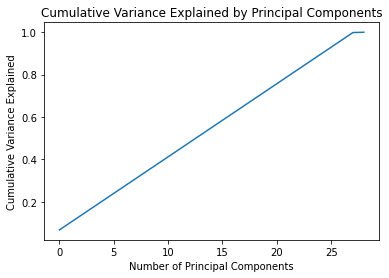

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
pca.fit(X_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.figure()
plt.plot(cumsum)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')

In [8]:
dim_95 = np.argmax(cumsum >= 0.85) + 1
print(f"Number of principal components needed to retain 95% of the variance is equal to : {dim_95}")

Number of principal components needed to retain 95% of the variance is equal to : 24


In [9]:
n_components = 24
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
columns = [f'PC{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(data=X_pca, columns=columns)

In [10]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
0,0.323706,-0.438681,0.119638,-0.274475,0.504804,0.010446,0.206205,0.718200,-0.214912,-0.460734,...,-0.114322,0.689745,-0.951755,-1.353662,0.662644,0.759791,0.816179,0.682077,0.733266,-0.407738
1,-0.472416,-0.294095,0.132279,0.801410,-0.580910,-0.135913,-0.242820,0.557107,-0.054678,0.248475,...,0.070918,0.270543,0.003612,-0.155087,-0.546761,0.086524,-0.541829,0.219267,0.041690,0.545476
2,1.774979,-0.143406,1.062528,-0.384473,-0.482041,0.857686,-0.651046,0.099594,-2.926246,0.907234,...,-1.054604,-0.375496,-1.172138,-1.260157,0.383679,0.492549,2.032578,1.550067,-0.673858,-1.506133
3,0.245283,0.171458,1.103605,0.002308,1.032708,-1.468551,-0.670076,-2.401807,-1.595302,-0.124835,...,-1.247022,0.701453,0.238503,-0.716555,0.457382,0.070336,0.059473,0.787761,-0.257404,0.402927
4,-0.065876,0.333169,-0.083784,-0.236284,0.559445,-0.355788,0.855319,0.019503,0.358221,0.088716,...,0.519914,-0.327568,-0.455114,-1.223756,0.613619,1.011752,0.644627,0.542530,-0.197150,-0.944399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-1.421777,-1.990802,-2.282983,-0.991219,0.191927,0.011991,-0.153582,-1.841978,0.280496,1.132234,...,-4.031302,-0.305649,4.938156,2.925600,6.651289,-2.941612,-1.513131,-1.593665,1.600975,-2.545939
284803,-0.327532,-0.022614,1.006395,-0.669183,-0.352137,0.366783,-0.458915,0.692558,-0.875017,0.673398,...,0.388979,0.383765,-1.468159,-0.555374,0.436336,0.906179,1.558033,-0.087956,-1.425670,-0.253022
284804,-0.118065,0.030470,1.010689,0.572298,-1.055025,0.952526,-1.939210,-0.394700,0.360316,0.219944,...,-0.145770,-1.002949,-1.651097,0.981397,-0.988114,1.000923,-0.941341,0.861675,0.928754,0.441959
284805,-0.415281,-0.104526,-0.074191,-0.324247,0.522271,0.103388,2.368417,0.164151,0.073613,-0.907173,...,0.004001,-0.116875,-2.202042,0.051574,0.193451,-0.275825,0.406662,1.530958,1.756351,-0.438564


# FEATURE SELECTION using Autoencoders

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

input_dim = X.shape[1] 
encoding_dim = 20  

autoencoder = Sequential()

# Encoder layers
autoencoder.add(Dense(24, input_shape=(input_dim,), activation='relu'))
autoencoder.add(Dense(encoding_dim, activation='relu'))

# Decoder layers
autoencoder.add(Dense(24, activation='relu'))
autoencoder.add(Dense(input_dim, activation='sigmoid'))

autoencoder.compile(optimizer='adam', loss='mean_squared_error',  metrics=['accuracy'])

# Train the autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, shuffle=True)

# Extract features using the encoder part of the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
X_encoded = encoder.predict(X_scaled)


# Create a DataFrame with the encoded features
columns = [f'AEC{i+1}' for i in range(encoding_dim)]
df_AEC = pd.DataFrame(data=X_encoded, columns=columns)


Epoch 1/50
8901/8901 [==============================] - 7s 783us/step - loss: 0.7643 - accuracy: 0.5687
Epoch 2/50
8901/8901 [==============================] - 7s 787us/step - loss: 0.7208 - accuracy: 0.6918
Epoch 3/50
8901/8901 [==============================] - 10s 1ms/step - loss: 0.7109 - accuracy: 0.7700
Epoch 4/50
8901/8901 [==============================] - 8s 845us/step - loss: 0.7076 - accuracy: 0.7845
Epoch 5/50
8901/8901 [==============================] - 6s 725us/step - loss: 0.7055 - accuracy: 0.7943
Epoch 6/50
8901/8901 [==============================] - 5s 562us/step - loss: 0.7049 - accuracy: 0.8154
Epoch 7/50
8901/8901 [==============================] - 5s 540us/step - loss: 0.7045 - accuracy: 0.8189
Epoch 8/50
8901/8901 [==============================] - 5s 553us/step - loss: 0.7042 - accuracy: 0.8217
Epoch 9/50
8901/8901 [==============================] - 5s 512us/step - loss: 0.7039 - accuracy: 0.8231
Epoch 10/50
8901/8901 [==============================] - 5s 539us

In [12]:
df_AEC

,AEC1,AEC2,AEC3,AEC4,AEC5,AEC6,AEC7,AEC8,AEC9,AEC10,AEC11,AEC12,AEC13,AEC14,AEC15,AEC16,AEC17,AEC18,AEC19,AEC20
0,3.399997,3.350268,2.070490,3.923510,5.804910,4.690724,3.577381,2.624564,4.237773,6.460435,7.349691,5.433467,5.516147,3.683073,6.456587,5.324872,6.119384,4.732521,4.273170,5.237740
1,3.259123,3.136459,6.720217,2.821558,4.174748,4.257555,3.733523,1.550718,6.093435,2.599350,5.035872,3.766545,1.417892,3.426452,2.025512,4.526514,5.522000,6.920812,3.207294,2.153465
2,5.514083,5.792971,2.072207,10.887881,10.615773,6.876300,4.025495,3.751724,10.486926,4.998475,7.852761,6.698345,5.246704,2.677579,8.896847,9.784435,6.266364,11.121435,5.850774,5.975783
3,4.523297,9.451435,1.764440,7.964665,5.250674,5.619663,3.174740,4.403363,7.724745,6.537484,3.946452,5.944974,2.434571,5.874364,3.957994,5.970232,5.465010,5.257945,4.024283,4.477828
4,3.757082,6.985779,0.835903,3.197806,5.577367,5.815514,6.421628,4.234631,4.745263,6.917017,7.637008,6.072339,5.265399,1.374329,7.120970,4.510016,8.279637,4.479966,4.052859,2.789463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,15.651002,6.476346,3.699875,0.000000,0.939553,9.251195,7.082742,6.959209,0.000000,2.221968,11.872884,3.306141,3.567354,5.266860,8.708531,15.358184,15.530862,5.759624,8.865960,5.626585
284803,2.650416,5.250567,2.468125,5.248614,7.065758,9.161251,6.863231,3.456936,4.928693,5.981474,6.274726,3.361331,4.597137,1.619313,5.085045,6.845173,7.207296,7.560125,4.018367,4.038968
284804,5.080348,1.933554,9.846227,5.412540,3.495756,3.999190,6.130712,8.824333,12.437031,5.662713,4.412973,3.483286,1.308554,2.085100,5.046151,6.780863,9.141593,10.119125,3.307288,8.781593
284805,6.597059,3.040435,1.602706,3.042363,4.917971,5.869171,4.211174,5.544131,5.608936,7.894925,8.602537,9.092431,4.824016,3.117891,9.164093,5.517907,10.663144,4.220461,6.001402,7.662840


# FEATURE SELECTION using Contrastive Learning

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)


class SiameseNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x1, x2):
        out1 = self.fc(x1)
        out2 = self.fc(x2)
        return out1, out2

class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

siamese_network = SiameseNetwork(input_size=29, output_size=24)
contrastive_loss = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(siamese_network.parameters(), lr=0.001)

class SiameseDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, index):
        x1 = self.X[index]
        label = self.y[index]
        x2 = self.X[torch.randint(len(self.X), (1,)).item()]
        return x1, x2, torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

batch_size = 64
train_dataset = SiameseDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

num_epochs = 3
for epoch in range(num_epochs):
    for x1, x2, label in train_loader:
        optimizer.zero_grad()
        output1, output2 = siamese_network(x1, x2)
        loss = contrastive_loss(output1, output2, label)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

siamese_network.eval()
with torch.no_grad():
    num_samples = len(X_tensor)
    indices = torch.randint(num_samples, (num_samples,))
    x1_eval = X_tensor
    x2_eval = X_tensor[indices]

    all_outputs, _ = siamese_network(x1_eval, x2_eval)

columns = [f'CL{i+1}' for i in range(24)]
df_CL = pd.DataFrame(data=all_outputs, columns=columns)

Epoch [1/3], Loss: 2.399999643465378e-11
Epoch [2/3], Loss: 2.399999643465378e-11
Epoch [3/3], Loss: 2.399999643465378e-11


# Treating the minority class as an anomaly and using anomaly detection techniques for classification

In [14]:
# For CL

clf = IsolationForest(contamination='auto', random_state=42)
clf.fit(df_CL)

y_pred = clf.predict(df_CL)

y_pred_binary = np.where(y_pred == 1, 0, 1)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred_binary))

# Print evaluation metrics
calinski_harabasz_index = calinski_harabasz_score(df_CL, y_pred_binary)
homogeneity = homogeneity_score(y, y_pred_binary)
completeness = completeness_score(y, y_pred_binary)
v_measure = v_measure_score(y, y_pred_binary)


print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")


Confusion Matrix:
[[284234     81]
 [   104    388]]
Calinski-Harabasz Index: 576644.6645222094
Homogeneity: 0.684416603623728
Completeness: 0.7133367943177018
V-Measure: 0.6985775126367709


In [15]:
# For PCA

clf = IsolationForest(contamination='auto', random_state=42)
clf.fit(df_pca)

y_pred = clf.predict(df_pca)

y_pred_binary = np.where(y_pred == 1, 0, 1)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred_binary))

# Print evaluation metrics
calinski_harabasz_index = calinski_harabasz_score(df_pca, y_pred_binary)
homogeneity = homogeneity_score(y, y_pred_binary)
completeness = completeness_score(y, y_pred_binary)
v_measure = v_measure_score(y, y_pred_binary)


print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

Confusion Matrix:
[[272137  12178]
 [    61    431]]
Calinski-Harabasz Index: 6466.791582772693
Homogeneity: 0.3228183549777148
Completeness: 0.022640559268896732
V-Measure: 0.04231350124456883


In [16]:
# For Auto-encoder

clf = IsolationForest(contamination='auto', random_state=42)
clf.fit(df_AEC)

y_pred = clf.predict(df_AEC)

y_pred_binary = np.where(y_pred == 1, 0, 1)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred_binary))

# Print evaluation metrics
calinski_harabasz_index = calinski_harabasz_score(df_AEC, y_pred_binary)
homogeneity = homogeneity_score(y, y_pred_binary)
completeness = completeness_score(y, y_pred_binary)
v_measure = v_measure_score(y, y_pred_binary)


print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

Confusion Matrix:
[[266603  17712]
 [    55    437]]
Calinski-Harabasz Index: 40996.81124719068
Homogeneity: 0.2870116315520225
Completeness: 0.015391673809798653
V-Measure: 0.02921654184421869


In [17]:
# For without feature selection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clf = IsolationForest(contamination='auto', random_state=42)
clf.fit(X_scaled)

y_pred = clf.predict(X_scaled)

y_pred_binary = np.where(y_pred == 1, 0, 1)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred_binary))

# Print evaluation metrics
calinski_harabasz_index = calinski_harabasz_score(X_scaled, y_pred_binary)
homogeneity = homogeneity_score(y, y_pred_binary)
completeness = completeness_score(y, y_pred_binary)
v_measure = v_measure_score(y, y_pred_binary)


print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

Confusion Matrix:
[[274629   9686]
 [    90    402]]
Calinski-Harabasz Index: 6009.115262568077
Homogeneity: 0.3092113693388358
Completeness: 0.02567836066574896
V-Measure: 0.04741883881434067


# Using K-means

In [18]:
# For CL
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_pred = kmeans.fit_predict(df_CL)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

# Print evaluation metrics
calinski_harabasz_index = calinski_harabasz_score(df_CL, y_pred)
homogeneity = homogeneity_score(y, y_pred)
completeness = completeness_score(y, y_pred)
v_measure = v_measure_score(y, y_pred)


print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

Confusion Matrix:
[[284254     61]
 [   126    366]]
Calinski-Harabasz Index: 604083.0909926749
Homogeneity: 0.6481757465866271
Completeness: 0.7327267883904061
V-Measure: 0.687862786951683


In [19]:
# For PCA
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_pred = kmeans.fit_predict(df_pca)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

# Print evaluation metrics
calinski_harabasz_index = calinski_harabasz_score(df_pca, y_pred)
homogeneity = homogeneity_score(y, y_pred)
completeness = completeness_score(y, y_pred)
v_measure = v_measure_score(y, y_pred)


print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

Confusion Matrix:
[[278787   5528]
 [   473     19]]
Calinski-Harabasz Index: 11845.237043824596
Homogeneity: 0.0010186715155261407
Completeness: 0.0001349258384561447
V-Measure: 0.00023828956935327151


In [20]:
# For Auto-encoder
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_pred = kmeans.fit_predict(df_AEC)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

# Print evaluation metrics
calinski_harabasz_index = calinski_harabasz_score(df_AEC, y_pred)
homogeneity = homogeneity_score(y, y_pred)
completeness = completeness_score(y, y_pred)
v_measure = v_measure_score(y, y_pred)


print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

Confusion Matrix:
[[282748   1567]
 [   121    371]]
Calinski-Harabasz Index: 70191.20649007458
Homogeneity: 0.4460768947454995
Completeness: 0.13922631258044968
V-Measure: 0.21221698567651034


In [21]:
# For without feature selection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_pred = kmeans.fit_predict(X_scaled)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

# Print evaluation metrics
calinski_harabasz_index = calinski_harabasz_score(X_scaled, y_pred)
homogeneity = homogeneity_score(y, y_pred)
completeness = completeness_score(y, y_pred)
v_measure = v_measure_score(y, y_pred)


print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

Confusion Matrix:
[[238086  46229]
 [   311    181]]
Calinski-Harabasz Index: 10257.48201880488
Homogeneity: 0.016621379589252205
Completeness: 0.0004754097641289101
V-Measure: 0.0009243801261972914


# For GMM

In [22]:
# For CL
n_clusters = 2
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
y_pred = gmm.fit_predict(df_CL)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

# Print evaluation metrics
calinski_harabasz_index = calinski_harabasz_score(df_CL, y_pred)
homogeneity = homogeneity_score(y, y_pred)
completeness = completeness_score(y, y_pred)
v_measure = v_measure_score(y, y_pred)


print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

Confusion Matrix:
[[284233     82]
 [   104    388]]
Calinski-Harabasz Index: 573126.022428341
Homogeneity: 0.6839331476117575
Completeness: 0.7115209833205699
V-Measure: 0.6974543626011157


In [23]:
# For PCA
n_clusters = 2
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
y_pred = gmm.fit_predict(df_pca)

# Evaluate t he model
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

# Print evaluation metrics
calinski_harabasz_index = calinski_harabasz_score(df_pca, y_pred)
homogeneity = homogeneity_score(y, y_pred)
completeness = completeness_score(y, y_pred)
v_measure = v_measure_score(y, y_pred)


print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

Confusion Matrix:
[[178110 106205]
 [   449     43]]
Calinski-Harabasz Index: 8843.722812584565
Homogeneity: 0.029359137356640582
Completeness: 0.000565114242105322
V-Measure: 0.0011088843175519427


In [24]:
# For Auto-encoder
n_clusters = 2
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
y_pred = gmm.fit_predict(df_AEC)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

# Print evaluation metrics
calinski_harabasz_index = calinski_harabasz_score(df_AEC, y_pred)
homogeneity = homogeneity_score(y, y_pred)
completeness = completeness_score(y, y_pred)
v_measure = v_measure_score(y, y_pred)


print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

Confusion Matrix:
[[226150  58165]
 [    30    462]]
Calinski-Harabasz Index: 16680.445990834392
Homogeneity: 0.17275248258121617
Completeness: 0.004320372168367781
V-Measure: 0.008429920202233368


In [25]:
# For without feature selection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 2
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
y_pred = gmm.fit_predict(X_scaled)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

# Print evaluation metrics
calinski_harabasz_index = calinski_harabasz_score(X_scaled, y_pred)
homogeneity = homogeneity_score(y, y_pred)
completeness = completeness_score(y, y_pred)
v_measure = v_measure_score(y, y_pred)


print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

Confusion Matrix:
[[179609 104706]
 [    51    441]]
Calinski-Harabasz Index: 5672.355392565628
Homogeneity: 0.08272935149907325
Completeness: 0.0015973318338359053
V-Measure: 0.0031341497499759664


# For OneClassSVM

In [26]:
# For CL
clf = OneClassSVM(nu=0.005)
y_pred = clf.fit_predict(df_CL)

y_pred_binary = np.where(y_pred == 1, 0, 1)
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred_binary))

# Print evaluation metrics
calinski_harabasz_index = calinski_harabasz_score(df_CL, y_pred_binary)
homogeneity = homogeneity_score(y, y_pred_binary)
completeness = completeness_score(y, y_pred_binary)
v_measure = v_measure_score(y, y_pred_binary)


print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

Confusion Matrix:
[[     9 284306]
 [     1    491]]
Calinski-Harabasz Index: 106.4752619634365
Homogeneity: 0.0008634643551991421
Completeness: 0.027776611284443847
V-Measure: 0.0016748638553971706


In [27]:
# For PCA
clf = OneClassSVM(nu=0.005)
y_pred = clf.fit_predict(df_pca)

y_pred_binary = np.where(y_pred == 1, 0, 1)
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred_binary))

# Print evaluation metrics
calinski_harabasz_index = calinski_harabasz_score(df_pca, y_pred_binary)
homogeneity = homogeneity_score(y, y_pred_binary)
completeness = completeness_score(y, y_pred_binary)
v_measure = v_measure_score(y, y_pred_binary)


print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

Confusion Matrix:
[[282723   1592]
 [   367    125]]
Calinski-Harabasz Index: 3592.853097597378
Homogeneity: 0.10127948607349785
Completeness: 0.03496980220128557
V-Measure: 0.051988874802710694


In [28]:
# For Auto-encoder
clf = OneClassSVM(nu=0.005)
y_pred = clf.fit_predict(df_AEC)

y_pred_binary = np.where(y_pred == 1, 0, 1)
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred_binary))

# Print evaluation metrics
calinski_harabasz_index = calinski_harabasz_score(df_AEC, y_pred_binary)
homogeneity = homogeneity_score(y, y_pred_binary)
completeness = completeness_score(y, y_pred_binary)
v_measure = v_measure_score(y, y_pred_binary)


print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

Confusion Matrix:
[[283134   1181]
 [   253    239]]
Calinski-Harabasz Index: 31475.050924197007
Homogeneity: 0.2619127472749787
Completeness: 0.10604163507409295
V-Measure: 0.15096249589677702


In [29]:
# For without feature selection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 2
clf = OneClassSVM(nu=0.005)
y_pred = clf.fit_predict(X_scaled)

y_pred_binary = np.where(y_pred == 1, 0, 1)
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred_binary))

# Print evaluation metrics
calinski_harabasz_index = calinski_harabasz_score(X_scaled, y_pred_binary)
homogeneity = homogeneity_score(y, y_pred_binary)
completeness = completeness_score(y, y_pred_binary)
v_measure = v_measure_score(y, y_pred_binary)


print(f"Calinski-Harabasz Index: {calinski_harabasz_index}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

Confusion Matrix:
[[282718   1597]
 [   360    132]]
Calinski-Harabasz Index: 2971.076154107819
Homogeneity: 0.10902573188917995
Completeness: 0.03742596207650297
V-Measure: 0.055723396521498235


In [30]:
# GMM, Kmeans, IsolationForest, OneClassSVM